# 3.2.3 Function approximation

In [2]:
import matplotlib.animation as animation
from math import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from IPython.display import clear_output
from PIL import Image

### Generate function data

In [3]:
# shaped Gauss function
def f(x, y):
    return np.exp(- (x**2 + y**2) / 10) - 0.5

def MSE(out, truth):
    res = 0
    for o, t in zip(out, truth):
        res += (o-t)**2
    res /= len(truth)
    return res

# A Perceptron
class Perceptron:
    def __init__(self, input_dim, lr):
        self.W = np.random.rand(input_dim+1) #Taking bias into account
        self.learning_rate = lr

    def activation_function(self, input):
        denominator = 1 + np.power(1/e, input)
        
        return (2 / denominator) - 1
    
    def grad(self, input):
        act_input = self.activation_function(input)
        return ((1 + act_input)*(1 - act_input) / 2)

    def forward(self, X):
       return self.activation_function(self.W @ X)

    def backward(self, X, df_out):
        # Forward pass
        # numpy shape : (column, row)
        hin = self.W @ X  # (input_dim) * (input_dim, bs) = (bs)
        delta = df_out * self.grad(hin) # Element wise multiplication => (bs)
        dW = (-1) * self.learning_rate * (delta @ X.T) # (bs) * (bs, input_dim) = (input_dim)
        df = np.expand_dims(self.W, axis=0).T @ np.expand_dims(delta, axis=0)
        self.W += dW
        return df # Need differential information for potential other layers


class TwoLayerPerceptron:
    def __init__(self, input_dim, nb_hidden, lr):
        self.learning_rate = lr
        self.hidden_perceptron = [Perceptron(input_dim, lr) for _ in range(nb_hidden)]
        self.out_perceptron = Perceptron(nb_hidden, lr)
    
    def forward(self, X):
        H = list()
        for p in self.hidden_perceptron:
            H.append(p.forward(X))
        # Add bias to h 
        H = np.concatenate((H, np.ones((1, X.shape[1]))), axis=0)
        out = self.out_perceptron.forward(H) # shape (bs)
        return out

    def backward(self, X, T):
        # forward pass
        hout = list()
        for p in self.hidden_perceptron:
            hout.append(p.forward(X))
        hout = np.concatenate((hout, np.ones((1, X.shape[1]))), axis=0) # (nb_hidden + 1, bs) for bias
        out = self.out_perceptron.forward(hout) # (bs)

        # backward pass
        df_out = self.out_perceptron.backward(hout, (out - T))
        for i, p in enumerate(self.hidden_perceptron):
            p.backward(X, df_out[i,:])

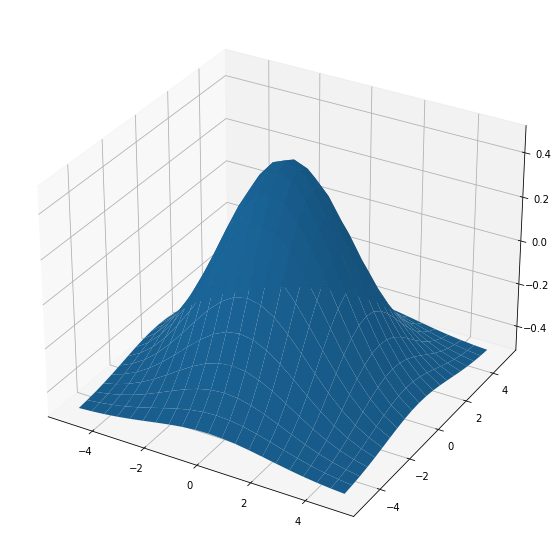

In [4]:
x = np.arange(-5, 5.5, 0.5)
y = np.arange(-5, 5.5, 0.5)

xx, yy = np.meshgrid(x, y)

z = f(xx, yy)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Tracer la surface 3D
ax.plot_surface(xx, yy, z)

In [5]:
# Reshape the data so that we can use it for training.
ndata = len(x)**2 #We used a mesh
targets = z.reshape(ndata, 1)
# Reshape 'xx' and 'yy' and stack them horizontally to create 'patterns' 
patterns = np.concatenate((xx.reshape(ndata, 1), yy.reshape(ndata, 1)), axis=1)
# Add bias & corresponding targets to shuffle
dataset = np.concatenate((patterns, np.ones((ndata, 1)), targets), axis=1)

shuffled_dataset = np.copy(dataset)
np.random.shuffle(shuffled_dataset)

shuffled_dataset.shape

(441, 4)

In [6]:
# Take a percentage of the dataset for training
training_prop = 0.8
index = int(shuffled_dataset.shape[0] * training_prop)

training_dataset = shuffled_dataset[:index]

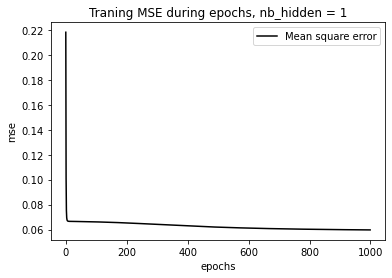

Last value of MSE : [0.05972585]


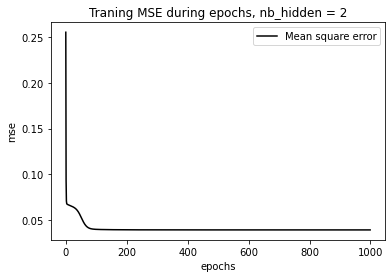

Last value of MSE : [0.03894121]


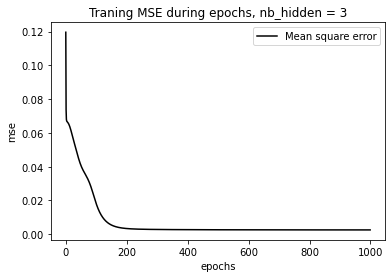

Last value of MSE : [0.00257953]


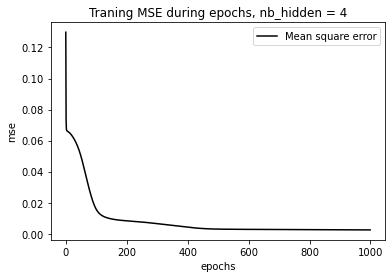

Last value of MSE : [0.00244399]


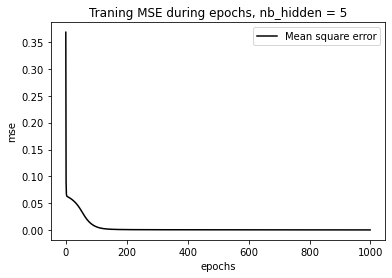

Last value of MSE : [0.00046856]


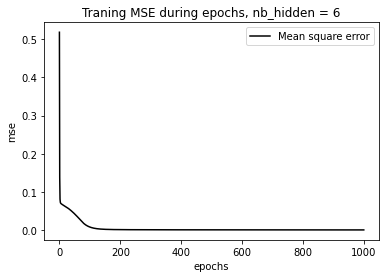

Last value of MSE : [0.00030635]


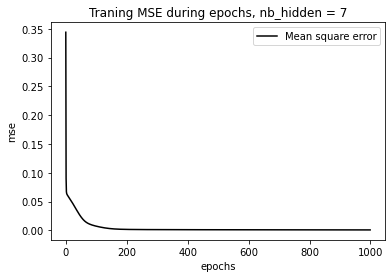

Last value of MSE : [0.0006587]


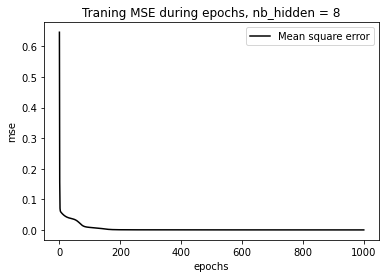

Last value of MSE : [0.00031664]


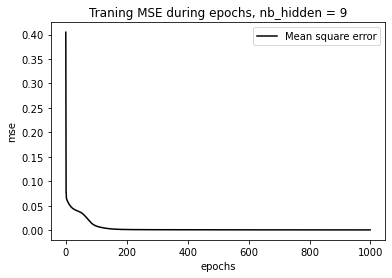

Last value of MSE : [0.0003889]


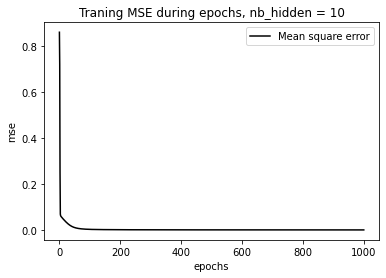

Last value of MSE : [0.00027574]


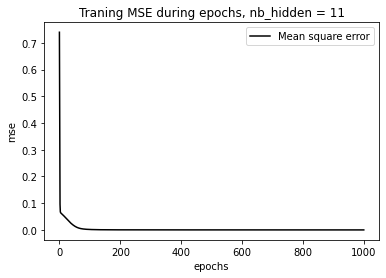

Last value of MSE : [0.00015699]


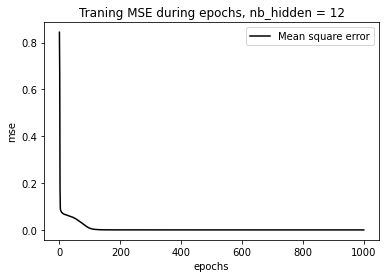

Last value of MSE : [0.00017343]


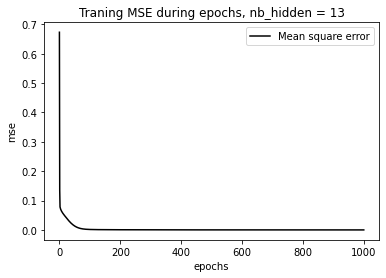

Last value of MSE : [0.00017358]


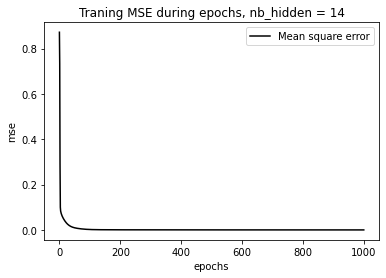

Last value of MSE : [0.0001811]


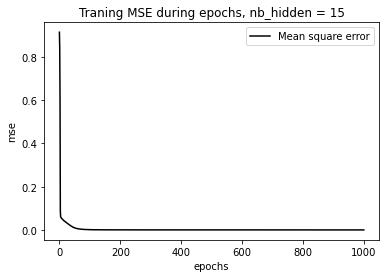

Last value of MSE : [0.00018323]


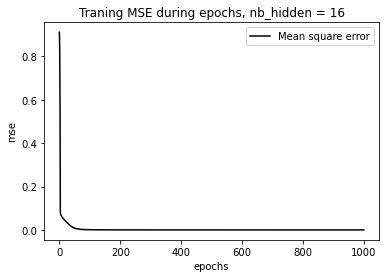

Last value of MSE : [0.00015042]


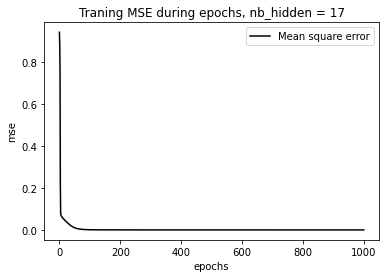

Last value of MSE : [7.96102793e-05]


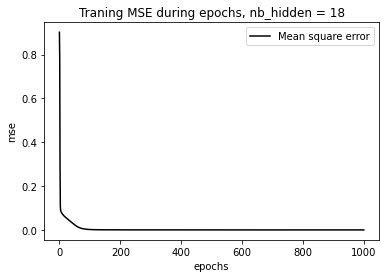

Last value of MSE : [0.00017917]


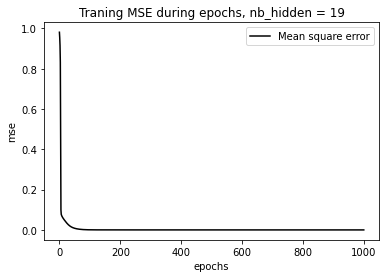

Last value of MSE : [7.30133297e-05]


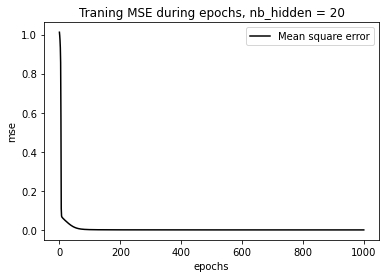

Last value of MSE : [0.00011929]


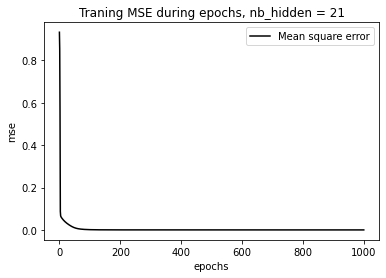

Last value of MSE : [0.00013508]


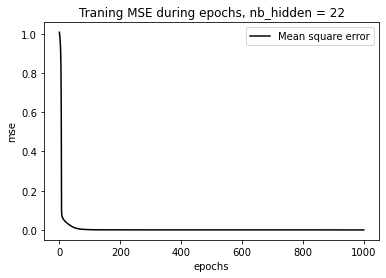

Last value of MSE : [0.00012073]


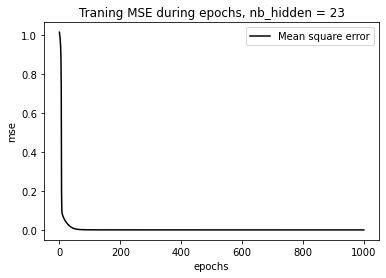

Last value of MSE : [9.17858022e-05]


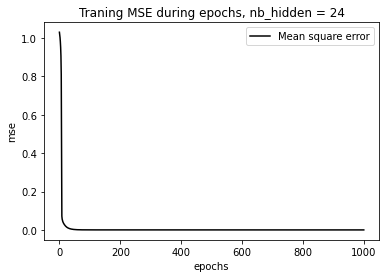

Last value of MSE : [6.66658175e-05]


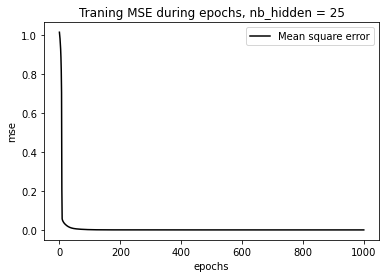

Last value of MSE : [6.80598464e-05]


In [12]:
# Training
lr = 0.01
epochs = 1000
batch_size = 1
nb_hidden = 1
training_dataset_size = len(training_dataset)

for nb_hidden in range(1, 26):
    network = TwoLayerPerceptron(2, nb_hidden, lr)

    # GIF & MSE variables
    frames = []
    wframe = None
    mse = []
    
    # Training
    for _ in range(epochs):
        idx = 0
        while idx < training_dataset_size:
            next_idx = idx + batch_size
            if next_idx <= training_dataset_size:
                network.backward(training_dataset[idx:next_idx,:3].T, training_dataset[idx:next_idx,3])
            # last batch
            else:
                network.backward(training_dataset[idx:,:3].T, training_dataset[idx:,3])
            idx = next_idx
        # Infering on all dataset
        out = network.forward(dataset[:,:3].T)

        #MSE
        mse.append(MSE(out, targets))
        
        # GENERATING FRAME
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        if wframe:
            wframe.remove()
        # Plot the new wireframe
        out = out.reshape((len(x), len(x)))
        ax.plot_wireframe(xx, yy, out)
        canvas = FigureCanvasAgg(plt.gcf())
        # Render the plot onto the canvas
        canvas.draw()
        # Get the PIL image from the canvas
        pil_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
        frames.append(pil_image)
        plt.close('all')

    frames[0].save(f'training_lr_{lr}_bs_{batch_size}_epochs_{epochs}_hidden_{nb_hidden}.gif', format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=300, loop=0)

    frames[-1].save(f"training_lr_{lr}_bs_{batch_size}_epochs_{epochs}_hidden_{nb_hidden}.png")

    # MSE
    x_curve = list(range(epochs))
    plt.plot(x_curve, mse, c='black', label='mse')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.title(f'Traning MSE during epochs, nb_hidden = {nb_hidden}')
    plt.legend(['Mean square error'])
    plt.show()

    print(f'Last value of MSE : {mse[-1]}')


In [18]:
training_dataset

array([[ 4.        ,  1.        ,  1.        , -0.31731648],
       [ 4.5       , -4.5       ,  1.        , -0.48257763],
       [ 2.        ,  4.5       ,  1.        , -0.41152188],
       ...,
       [-1.        , -3.5       ,  1.        , -0.23419704],
       [-4.        , -4.        ,  1.        , -0.4592378 ],
       [ 2.5       , -2.        ,  1.        , -0.14120353]])

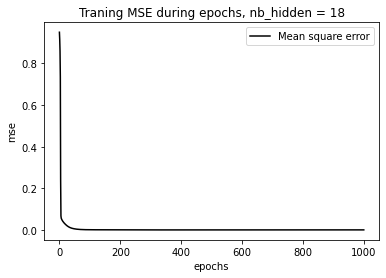

Last value of MSE : [0.0007532]


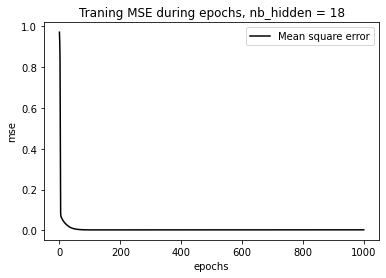

Last value of MSE : [0.00324835]


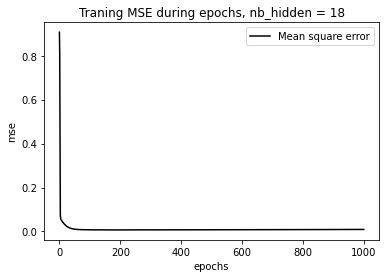

Last value of MSE : [0.00930692]


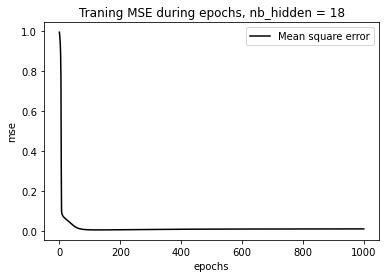

Last value of MSE : [0.01237251]


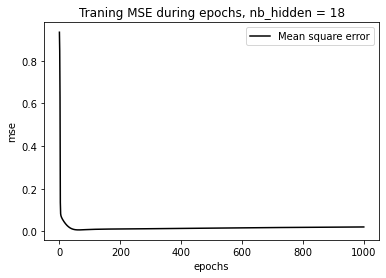

Last value of MSE : [0.02044404]


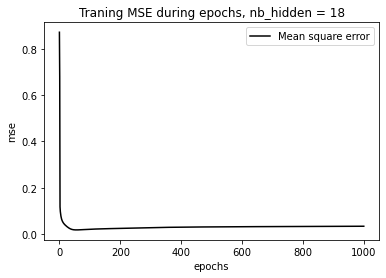

Last value of MSE : [0.03379459]


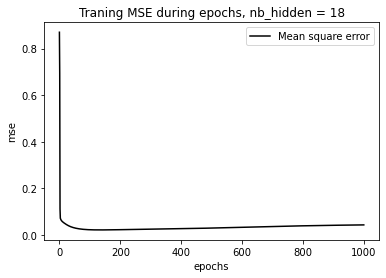

Last value of MSE : [0.04374632]


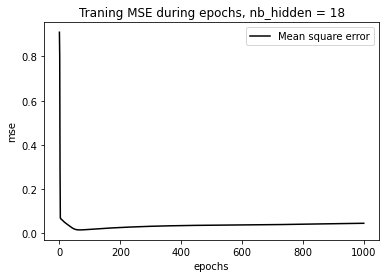

Last value of MSE : [0.04580027]


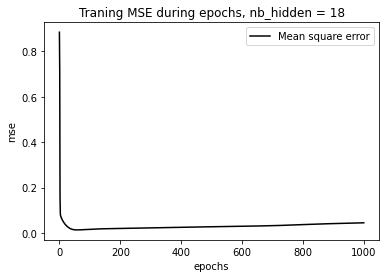

Last value of MSE : [0.04533871]


In [23]:
# Training
lr = 0.01
epochs = 1000
batch_size = 1
nb_hidden = 18
training_dataset_size = len(training_dataset)

for sigma in range(1, 10):
    network = TwoLayerPerceptron(2, nb_hidden, lr)

    # Adding noise to training
    training_dataset_noise = np.copy(training_dataset)
    training_dataset_noise[:,3] += np.random.normal(0, 0.1*sigma, (training_dataset.shape[0]))

    # GIF & MSE variables
    frames = []
    wframe = None
    mse = []
    
    # Training
    for _ in range(epochs):
        idx = 0
        while idx < training_dataset_size:
            next_idx = idx + batch_size
            if next_idx <= training_dataset_size:
                network.backward(training_dataset_noise[idx:next_idx,:3].T, training_dataset_noise[idx:next_idx,3])
            # last batch
            else:
                network.backward(training_dataset_noise[idx:,:3].T, training_dataset_noise[idx:,3])
            idx = next_idx
        # Infering on all dataset
        out = network.forward(dataset[:,:3].T)

        #MSE
        mse.append(MSE(out, targets))
        
        # GENERATING FRAME
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        if wframe:
            wframe.remove()
        # Plot the new wireframe
        out = out.reshape((len(x), len(x)))
        ax.plot_wireframe(xx, yy, out)
        canvas = FigureCanvasAgg(plt.gcf())
        # Render the plot onto the canvas
        canvas.draw()
        # Get the PIL image from the canvas
        pil_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
        frames.append(pil_image)
        plt.close('all')

    frames[0].save(f'training_lr_{lr}_bs_{batch_size}_epochs_{epochs}_hidden_{nb_hidden}_noise_{sigma}.gif', format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=300, loop=0)

    frames[-1].save(f"training_lr_{lr}_bs_{batch_size}_epochs_{epochs}_hidden_{nb_hidden}_noise_{sigma}.png")

    # MSE
    x_curve = list(range(epochs))
    plt.plot(x_curve, mse, c='black', label='mse')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.title(f'Traning MSE during epochs, nb_hidden = {nb_hidden}')
    plt.legend(['Mean square error'])
    plt.show()

    print(f'Last value of MSE : {mse[-1]}')


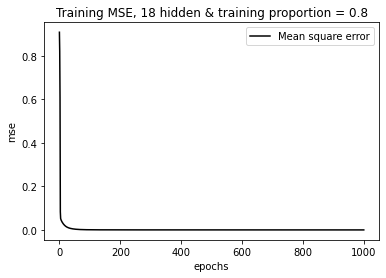

Last value of MSE : [9.07290163e-05]


In [8]:
# Training
lr = 0.01
epochs = 1000
batch_size = 1
nb_hidden = 18
training_dataset_size = len(training_dataset)

for training_percent in [8]:
    network = TwoLayerPerceptron(2, nb_hidden, lr)

    # GIF & MSE variables
    frames = []
    wframe = None
    mse = []

    training_prop = training_percent/10
    index = int(shuffled_dataset.shape[0] * training_prop)
    training_dataset = shuffled_dataset[:index]
    training_dataset_size = len(training_dataset)
    # Training
    for _ in range(epochs):
        idx = 0
        while idx < training_dataset_size:
            next_idx = idx + batch_size
            if next_idx <= training_dataset_size:
                network.backward(training_dataset[idx:next_idx,:3].T, training_dataset[idx:next_idx,3])
            # last batch
            else:
                network.backward(training_dataset[idx:,:3].T, training_dataset[idx:,3])
            idx = next_idx
        # Infering on all dataset
        out = network.forward(dataset[:,:3].T)

        #MSE
        mse.append(MSE(out, targets))
        
        # GENERATING FRAME
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111, projection='3d')
        if wframe:
            wframe.remove()
        # Plot the new wireframe
        out = out.reshape((len(x), len(x)))
        ax.plot_wireframe(xx, yy, out)
        canvas = FigureCanvasAgg(plt.gcf())
        # Render the plot onto the canvas
        canvas.draw()
        # Get the PIL image from the canvas
        pil_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
        frames.append(pil_image)
        plt.close('all')

    frames[0].save(f'training_lr_{lr}_bs_{batch_size}_epochs_{epochs}_hidden_{nb_hidden}_prop_{training_prop}.gif', format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=300, loop=0)

    frames[-1].save(f"training_lr_{lr}_bs_{batch_size}_epochs_{epochs}_hidden_{nb_hidden}_prop_{training_prop}.png")

    # MSE
    x_curve = list(range(epochs))
    plt.plot(x_curve, mse, c='black', label='mse')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.title(f'Training MSE, 18 hidden & training proportion = {training_prop}')
    plt.legend(['Mean square error'])
    plt.show()

    print(f'Last value of MSE : {mse[-1]}')


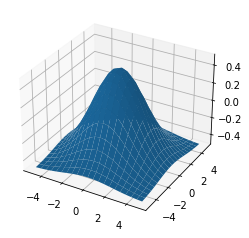

In [15]:
out = network.forward(dataset[:,:3].T)
out = out.reshape((len(x), len(x)))
#xx, yy = np.meshgrid(x, y)

#z = f(xx, yy)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Tracer la surface 3D
ax.plot_surface(xx, yy, z)
plt.show()


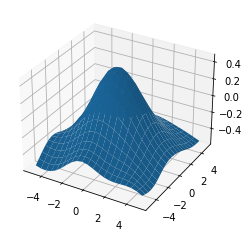

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, out)
plt.show()

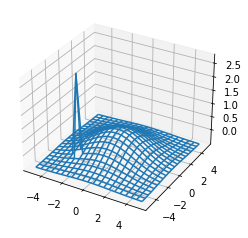

In [24]:
# Begin plotting.

z_train = np.copy(z)
frames = []
wframe = None
i = 0
for _ in range(100):
    # If a line collection is already remove it before drawing.
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    if wframe:
        wframe.remove()
    # Plot the new wireframe and pause briefly before continuing.
    ax.plot_wireframe(xx, yy, z_train)
    canvas = FigureCanvasAgg(plt.gcf())

    # Render the plot onto the canvas
    canvas.draw()

    # Get the PIL image from the canvas
    pil_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())

    frames.append(pil_image)

    z_train[5, 5] += 0.03
    i+=1
    plt.pause(.1)
    clear_output(wait=True)
    plt.show()

frames[0].save('png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

In [ ]:
n = 100
mA = [10, 10]
sigma = 1
aX = np.random.normal(mA[0], sigma, n)
aY = np.random.normal(mA[1], sigma, n)
a = np.stack((aX, aY, np.ones(n), np.zeros(n)), axis=1)
mB = [5, 5]
sigma = 1
bX = np.random.normal(mB[0], sigma, n)
bY = np.random.normal(mB[1], sigma, n)  
mB = [5, 5]
sigma = 1
bX = np.random.normal(mB[0], sigma, n)
bY = np.random.normal(mB[1], sigma, n)
b = np.stack((bX, bY, np.ones(n), np.ones(n)), axis=1)
b.shape
dataset = np.concatenate((a, b), axis=0)
np.random.shuffle(dataset)

dataset[:,3] = 2 * (dataset[:,3] - 0.5)
print(dataset)

learning_rate = 0.0001
epochs = 1000
batch_size = 30
dataset_size = len(dataset)

net = TwoLayerPerceptron(2, 3, learning_rate)

for _ in range(epochs):
    idx = 0
    while idx < dataset_size:
        next_idx = idx + batch_size
        if next_idx <= dataset_size:
            net.backward(dataset[idx:next_idx,:3].T, dataset[idx:next_idx,3])
        # last batch
        else:
            net.backward(dataset[idx:,:3].T, dataset[idx:,3])
        idx = next_idx

res = net.forward(dataset[:,:3].T)

(2 * ((res > 0) - 0.5)) == dataset[:,3]